# House Price Kaggle Project


In [199]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
import tflearn
import tensorflow as tf
import pylab 
import scipy.stats as stats
warnings.filterwarnings('ignore')
%matplotlib inline

In [200]:
#read the csv file
df_train = pd.read_csv('train.csv')

## 1. Data Visualization and Exploration


### 1.1 Price Analysis


### Histogram of price


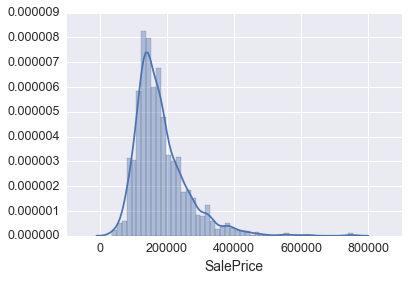

In [201]:
sns.distplot(df_train['SalePrice'], hist = True)

### Summary of sale price


In [202]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### Segment price into "low", "medium" and "high" and visualize the price range on Google Map

In [203]:
low = df_train[df_train['SalePrice'] < 130000]
medium = df_train[(df_train['SalePrice'] >= 130000) & (df_train['SalePrice'] <= 210000)]
high = df_train[df_train['SalePrice'] > 210000]

### Relationship between house price and other features


### scatter plot of price and great living area

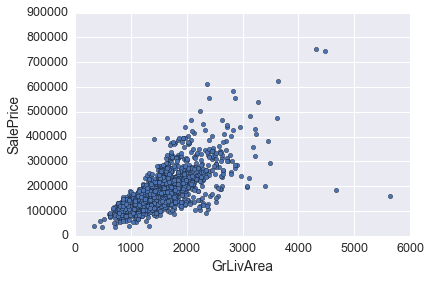

In [204]:
data = pd.concat([df_train['GrLivArea'], df_train['SalePrice']], axis = 1)
data.plot.scatter(x = 'GrLivArea', y = 'SalePrice', ylim = (0, 900000))

### scatter plot of price and lot area

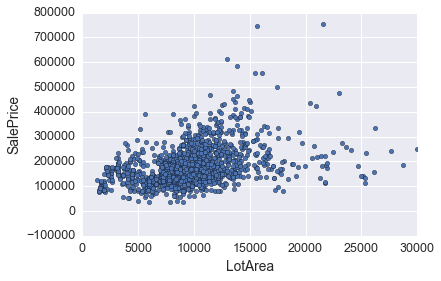

In [205]:
data = pd.concat([df_train['LotArea'], df_train['SalePrice']], axis = 1)
#we zoom in the plot in lot area from 0 to 30000
data.plot.scatter(x = 'LotArea', y = 'SalePrice', xlim = [0,30000])

### relationship between price and overall quality

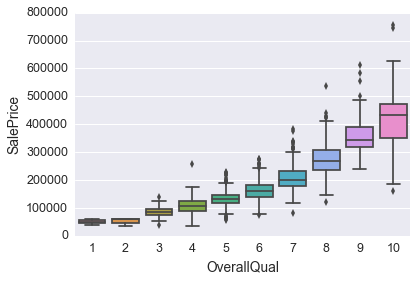

In [206]:
data = pd.concat([df_train['SalePrice'], df_train['OverallQual']], axis = 1)
fig = sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = data)

### relationship between price and 1st floor SF

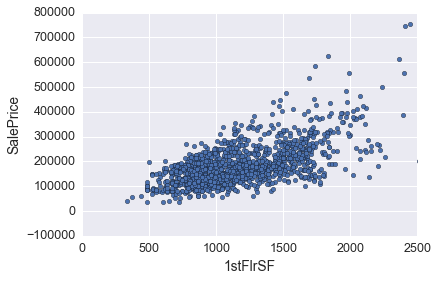

In [210]:
data = pd.concat([df_train['SalePrice'], df_train['1stFlrSF']], axis = 1)
data.plot.scatter(x = '1stFlrSF', y = 'SalePrice', xlim = [0,2500])

### relationship between price and Neighborhood

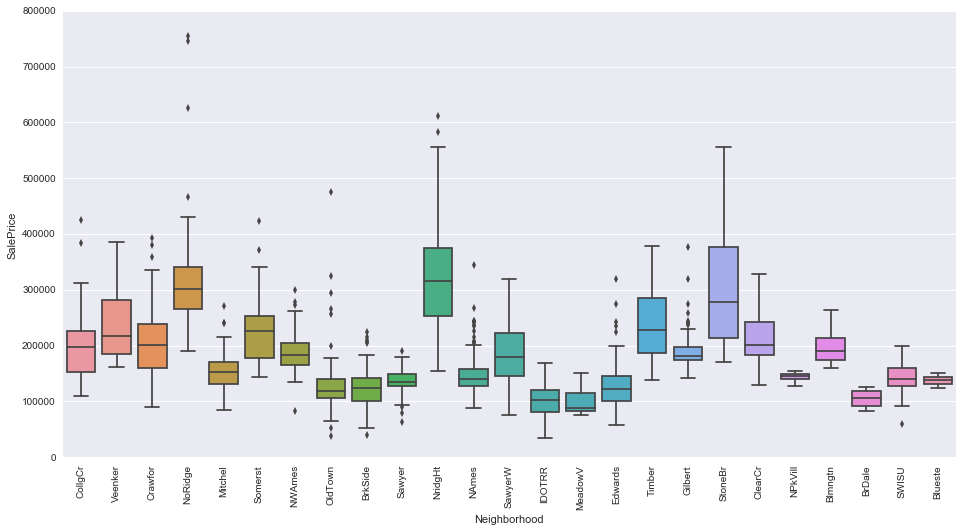

In [8]:
data = pd.concat([df_train['SalePrice'], df_train['Neighborhood']], axis = 1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x = 'Neighborhood', y = 'SalePrice', data = data)
plt.xticks(rotation=90);

### relationship between price and year built

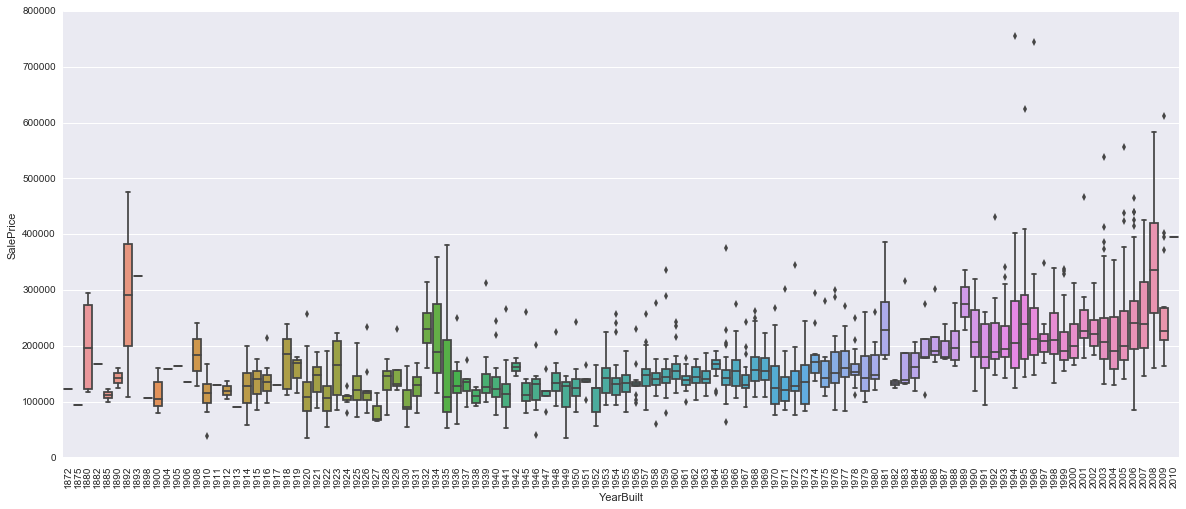

In [9]:
data = pd.concat([df_train['SalePrice'], df_train['YearBuilt']], axis = 1)
f, ax = plt.subplots(figsize=(20, 8))
sns.boxplot(x = 'YearBuilt', y = 'SalePrice', data = data)
plt.xticks(rotation=90);

###  1.2 Find out the relationship among features


### Heat map of correlation matrix

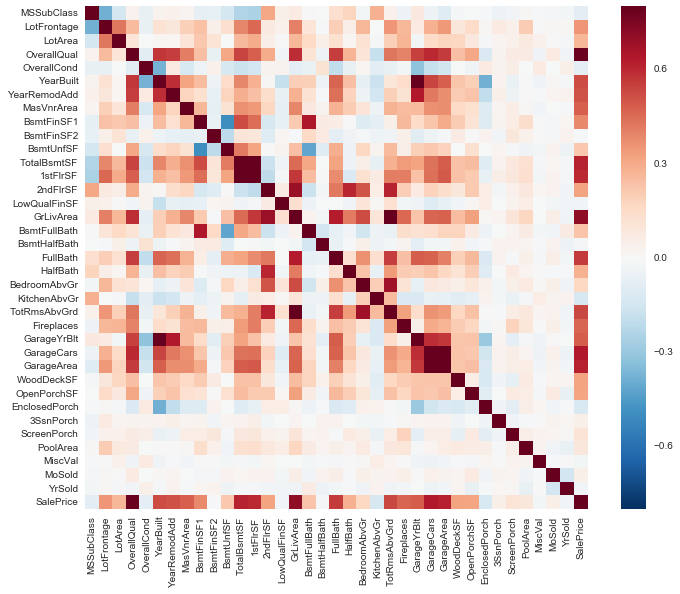

In [29]:
#correlation matrix
data = pd.read_csv('train.csv')
del data['Id']
corrmat = data.corr()
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat, cbar=True, vmax=.8, square=True)

### correlation matrix of the 10 features that are significantly correlated to "price"

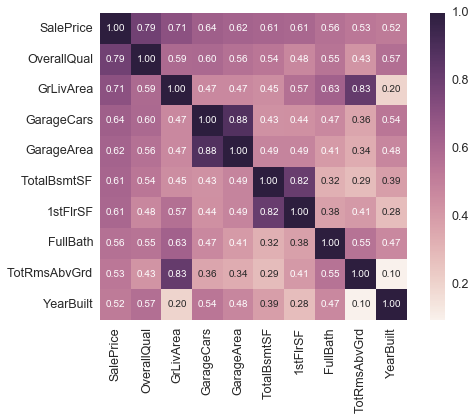

In [37]:
#correlation matrix with less features
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
#dataframe.T ---> transpose matrix
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

### scatter plot between 'SalePrice' and correlated variables

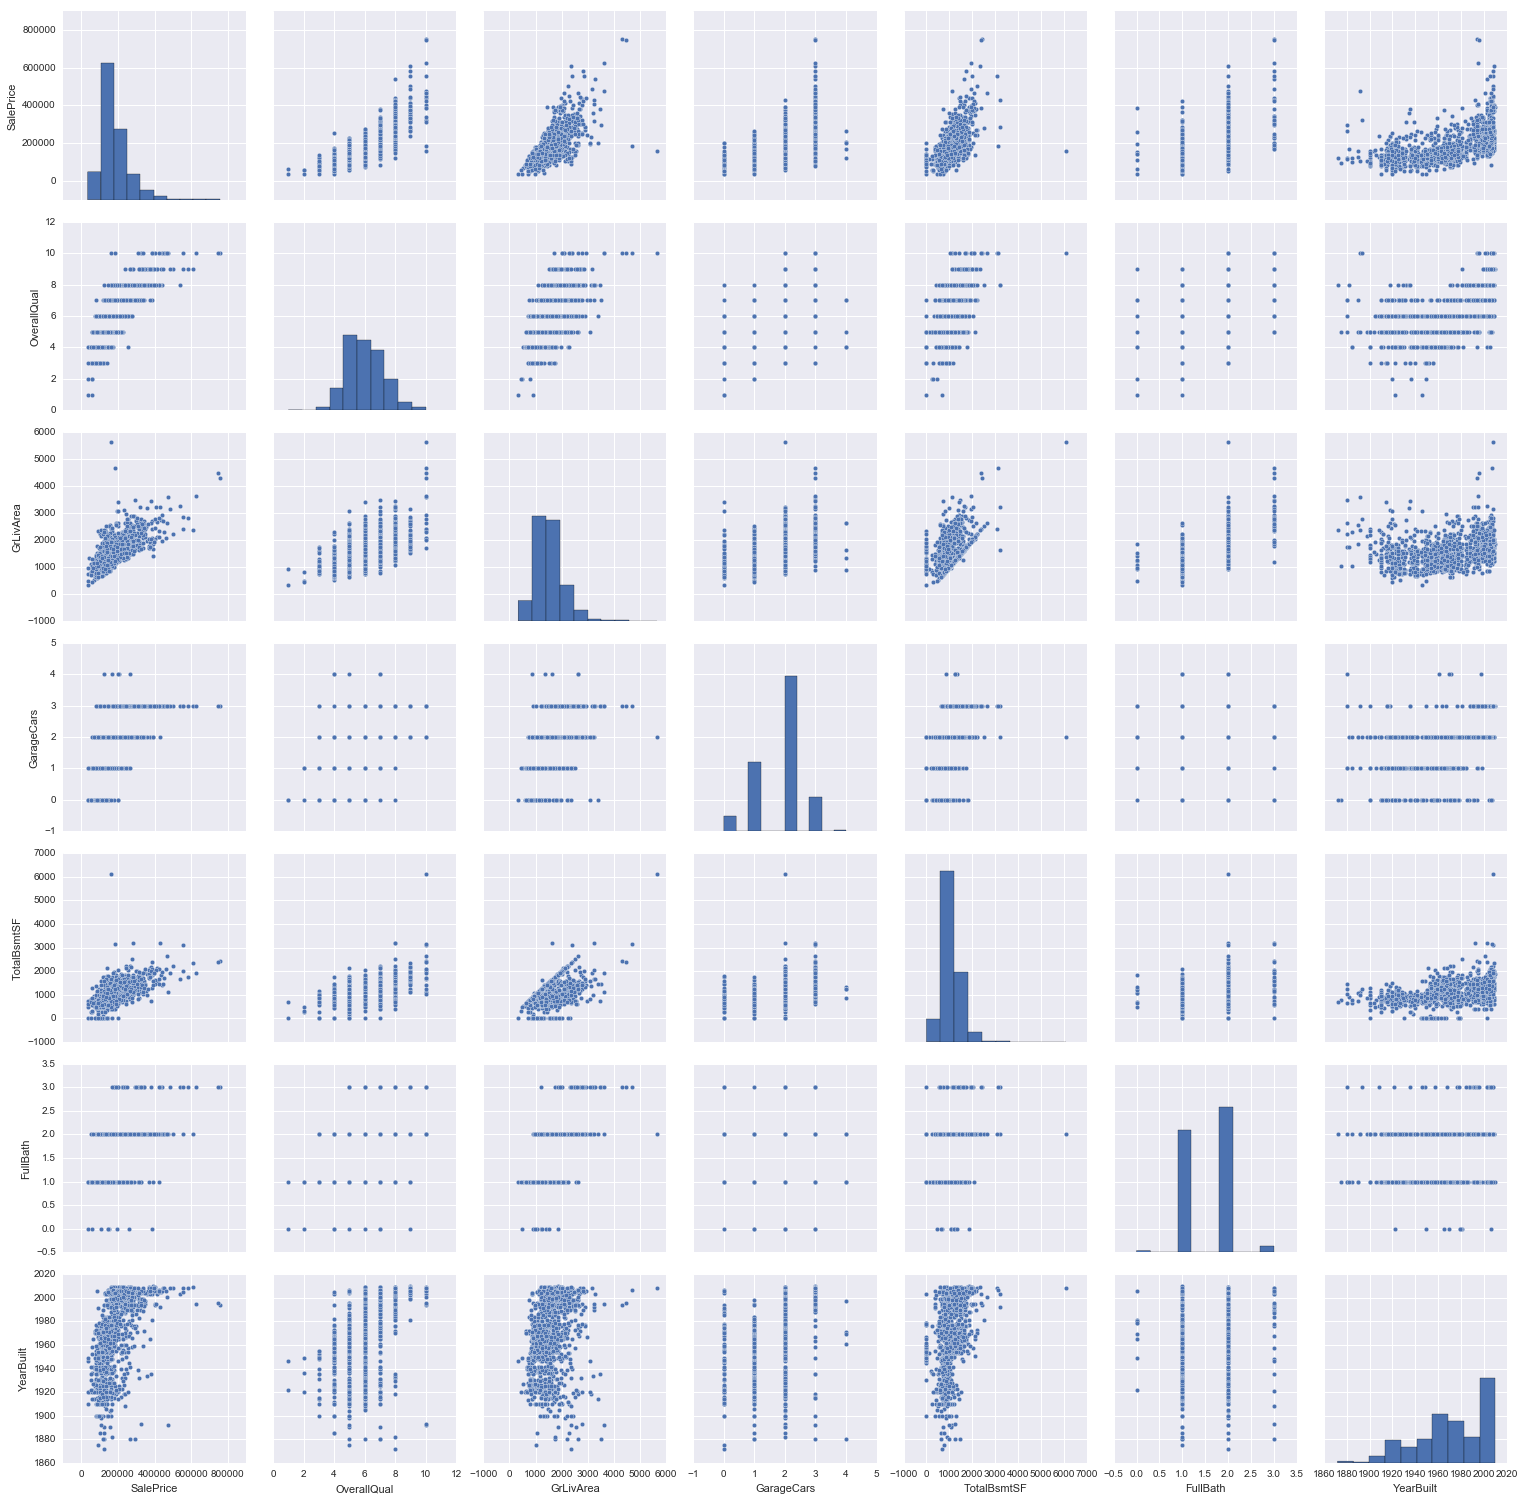

In [12]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath','YearBuilt']
sns.pairplot(df_train[cols], size = 3)
plt.show()

In [236]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data = pd.concat([train, test], axis = 0)
nans = pd.isnull(data).sum()
nans[nans>0]
Y = train['SalePrice']
nans

1stFlrSF            0
2ndFlrSF            0
3SsnPorch           0
Alley            2721
BedroomAbvGr        0
BldgType            0
BsmtCond           82
BsmtExposure       82
BsmtFinSF1          1
BsmtFinSF2          1
BsmtFinType1       79
BsmtFinType2       80
BsmtFullBath        2
BsmtHalfBath        2
BsmtQual           81
BsmtUnfSF           1
CentralAir          0
Condition1          0
Condition2          0
Electrical          1
EnclosedPorch       0
ExterCond           0
ExterQual           0
Exterior1st         1
Exterior2nd         1
Fence            2348
FireplaceQu      1420
Fireplaces          0
Foundation          0
FullBath            0
                 ... 
LotShape            0
LowQualFinSF        0
MSSubClass          0
MSZoning            4
MasVnrArea         23
MasVnrType         24
MiscFeature      2814
MiscVal             0
MoSold              0
Neighborhood        0
OpenPorchSF         0
OverallCond         0
OverallQual         0
PavedDrive          0
PoolArea  

## 2. Data Preprocessing

### Drop ID and features with more than one thousands missing values

In [237]:
data = data.drop('Id', 1)
data = data.drop('Alley', 1)
data = data.drop('PoolQC', 1)
data = data.drop('Fence', 1)
data = data.drop('MiscFeature', 1)
data = data.drop('SalePrice', 1)

### Select features that have a strong correaltion with "Price"

In [238]:
cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
data = data[cols]

### Hot encoding
### Fill NaN with medium
### Log transformation
### change -inf to 0 


In [239]:
#Hot Encoding
data = pd.get_dummies(data)
#fill missing data with median
imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
data = imp.fit_transform(data)
#Log transformation
#data = np.log(data)

#change -inf to 0
data[data == -np.inf] = 0

## 3. Linear Regression


In [240]:
#split the data into training and test set
train = data[:1460]
test = data[1460:]
linear = linear_model.LinearRegression(fit_intercept = True)
linear.fit(train, Y, sample_weight = None)
linear.score(train, Y, sample_weight = None)

0.77030254503471296

In [241]:
linear.get_params(deep = True)

{'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'normalize': False}

In [242]:
Y_pred = linear.predict(test)
Y = Y[:1459]

### Count the number of data points that have residual less than 1

In [243]:
sum(abs(Y-Y_pred)<50000)

613

### Plot the histogram of residuals

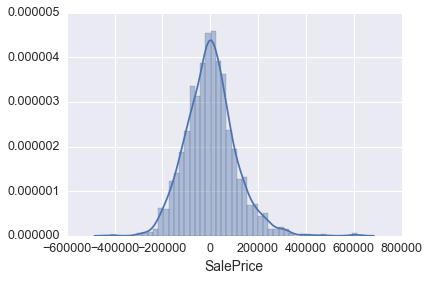

In [244]:
residual = Y-Y_pred
sns.distplot(residual, hist = True)

### Scatter plot of the residual

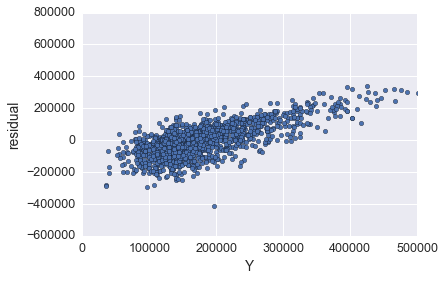

In [245]:
#scatter plot of price and lot area
d = {'Y' : pd.Series(Y), 'residual' : pd.Series(residual)}
res = pd.DataFrame(d)
#we zoom in the plot in lot area from 0 to 30000
res.plot.scatter(x = 'Y', y = 'residual', xlim = (0, 500000))

### Check the normality of the residual by plotting the Q-Q plot

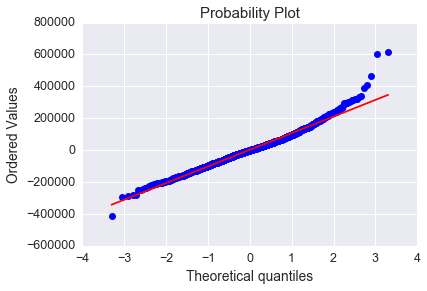

In [246]:
stats.probplot(residual, dist="norm", plot=pylab)
pylab.show()